<h2
    style="font-size:20px; font-family:'Helvetica Neue'" align="right"> Viktor Trokhymenko 
</h2>
<h3 
    style="font-size:16px; font-family:'Helvetica Neue'" align="right"> @vtrokhymenko
</h3>

In [122]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
np.random.seed(42)
import re
from pprint import pprint
import ast

import nltk
from nltk.corpus import stopwords

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt
%matplotlib inline

In [128]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.cluster import KMeans

### в качестве датасета, возьмем "новую газету" с уже сделанным препроцессингом

In [12]:
df = pd.read_csv('data/novayagazeta_mystem1.csv')
df.head()

,id,text_clean_lemma
0,1408695844,"['предсказывать', 'страница', 'также', 'сайт',..."
1,1408695844,"['август', 'освобождать', 'заключать', 'площад..."
2,1408695844,"['август', 'россия', 'время', 'трагический', '..."
3,1408695844,"['избирательный', 'округ', 'район', 'выхино-жу..."
4,1408695844,"['белоруссия', 'казахстан', 'который', 'россия..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14485 entries, 0 to 14484
Data columns (total 2 columns):
id                  14485 non-null int64
text_clean_lemma    14485 non-null object
dtypes: int64(1), object(1)
memory usage: 226.4+ KB


приведем поле `text_clean_lemma1` к __literal_eval__

In [13]:
%%time
df['text_clean_lemma'] = df.text_clean_lemma.apply(lambda x: ast.literal_eval(x))

CPU times: user 7.63 s, sys: 316 ms, total: 7.94 s
Wall time: 7.98 s


сджойним листы, тк это требуется для sklearn lda

In [14]:
df['text_clean_lemma4sk'] = df.text_clean_lemma.apply(lambda x: ' '.join(x))
df.head(1)

,id,text_clean_lemma,text_clean_lemma4sk
0,1408695844,"[предсказывать, страница, также, сайт, новый, ...",предсказывать страница также сайт новый иван с...


# LDA

* ## tf dtm

In [15]:
%%time
tf_vectorizer = CountVectorizer()

dtm_tf = tf_vectorizer.fit_transform(df.text_clean_lemma4sk)
print(dtm_tf.shape)

(14485, 106332)
CPU times: user 3.3 s, sys: 102 ms, total: 3.4 s
Wall time: 3.41 s


In [127]:
print(tf_vectorizer.get_feature_names()[:10])
print(tf_vectorizer.get_feature_names()[-10:])

['aa', 'aaa', 'aaaruдва', 'aadolu', 'aalysis', 'aalyticks', 'aalytics', 'aarcho', 'aaroso', 'aastasia']
['єдина', 'ім', 'ірина', 'іще', 'їдем', 'اديك', 'الاستقرار', 'خالد', 'خوجة', 'فى']


In [29]:
# Materialize the sparse data
data_dense = dtm_tf.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum() / data_dense.size) * 100)

Sparsicity:  0.17583064257965078


In [54]:
%%time

lda_tf = LatentDirichletAllocation(
    n_components=30,  #like n_topics           
    max_iter=7,
    learning_method='online',
    random_state=42)

lda_tf.fit_transform(dtm_tf)

CPU times: user 2min 41s, sys: 10.8 s, total: 2min 52s
Wall time: 2min 51s


In [55]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_tf.score(dtm_tf))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_tf.perplexity(dtm_tf))

Log Likelihood:  -35697440.532259
Perplexity:  6515.04829845018


Create Document - Topic Matrix

In [70]:
%%time
lda_output = lda_tf.transform(dtm_tf)

CPU times: user 5.35 s, sys: 273 ms, total: 5.62 s
Wall time: 5.41 s


column names

In [62]:
topicnames = ["Topic" + str(i) for i in range(lda_tf.n_components)]
print(topicnames)

['Topic0', 'Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11', 'Topic12', 'Topic13', 'Topic14', 'Topic15', 'Topic16', 'Topic17', 'Topic18', 'Topic19', 'Topic20', 'Topic21', 'Topic22', 'Topic23', 'Topic24', 'Topic25', 'Topic26', 'Topic27', 'Topic28', 'Topic29']


index names

In [64]:
docnames = [
    "Doc" + str(i) for i in range(len(df.text_clean_lemma4sk.values.tolist()))
]
len(docnames)

14485

Make the pandas dataframe

In [72]:
df_document_topic = pd.DataFrame(
    np.round(lda_output, 2), columns=topicnames, index=docnames)
print(df_document_topic.shape)
df_document_topic.head(2)

(14485, 30)


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29
Doc0,0.0,0.01,0.0,0.06,0.01,0.0,0.0,0.0,0.0,0.54,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0
Doc1,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.29,...,0.0,0.0,0.13,0.0,0.0,0.0,0.0,0.13,0.0,0.0


Get dominant topic for each document

In [73]:
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

In [75]:
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)


def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

In [78]:
# Apply Style

df_document_topics = df_document_topic.head(15).style.applymap(
    color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,dominant_topic
Doc0,0,0.01,0,0.06,0.01,0,0,0,0,0.54,0,0.15,0,0.22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9
Doc1,0,0,0,0,0,0,0,0,0,0.29,0,0.03,0.01,0,0,0,0,0,0,0.42,0,0,0.13,0,0,0,0,0.13,0,0,19
Doc2,0,0.01,0,0,0.01,0.01,0,0,0,0.26,0,0.05,0,0.06,0.01,0,0,0,0,0.05,0.3,0,0.02,0,0.19,0,0.03,0,0,0,20
Doc3,0,0,0,0,0.06,0.23,0,0,0,0.3,0.02,0.05,0,0.04,0,0.01,0,0,0,0.26,0,0,0.02,0,0,0,0,0,0,0,9
Doc4,0,0,0.01,0,0,0,0,0,0,0.51,0.01,0.05,0,0.42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9
Doc5,0,0,0,0,0.48,0,0,0,0,0.38,0,0,0,0.03,0,0,0,0,0,0.04,0,0.02,0.03,0,0,0,0,0.02,0,0,4
Doc6,0,0,0,0,0.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
Doc7,0,0,0,0,0.14,0,0,0,0,0.43,0,0.01,0,0.04,0,0,0,0,0,0.37,0,0,0,0,0,0,0,0.01,0,0,9
Doc8,0,0,0,0,0,0,0,0,0,0,0,0,0,0.16,0,0,0,0,0.26,0,0,0.28,0.27,0,0,0,0,0,0,0,21
Doc9,0,0,0,0,0,0,0,0,0,0.15,0,0.46,0,0.37,0,0.01,0,0,0,0,0.01,0,0,0,0,0,0,0,0,0,11


In [81]:
df_topic_distribution = df_document_topic['dominant_topic']\
                        .value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,11,4509
1,9,2859
2,13,2082
3,24,1622
4,22,1458
5,19,463
6,4,378
7,5,285
8,20,264
9,27,259


In [84]:
%%time
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='tsne')

CPU times: user 13.5 s, sys: 2.57 s, total: 16 s
Wall time: 38.3 s


In [88]:
pyLDAvis.save_html(panel, 'pyLDAvis/sklearn/tsne_tf-dtm_sk.html')

In [85]:
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
9      106.024231  -17.086622       1        1  30.417402
11      60.253143  -36.174786       2        1  16.534182
13     -84.168816   38.033707       3        1  10.421151
19      96.446220   35.873447       4        1   8.677223
24     -25.686543  115.628105       5        1   7.059280
22     -50.960449   70.090660       6        1   6.262557
27      -2.551305   69.101418       7        1   4.821514
4     -132.296600   15.867651       8        1   3.389463
5       26.484432  108.782906       9        1   2.852933
2       76.011948   86.144356      10        1   1.690938
20     -92.982506  -72.571777      11        1   1.237213
21      11.614546   22.191828      12        1   1.232295
29    -119.822021   69.182327      13        1   1.187039
26     -56.148323  -38.975288      14        1   0.570993
10      20.559931  -20.267712      15        1   0.553477
14      86.808701  -75.397675      16        1   0.385047
8       45.505421 -114.242355      17        1   0.303216
18     -41.323307  -80.389816      18        1   0.281039
28     -80.448647  107.156174      19        1   0.278335
23      41.227642   54.029938      20        1   0.254600
12    -136.134186  -43.674374      21        1   0.214885
1      -20.080067   -9.638962      22        1   0.203954
3      -58.953583    4.751249      23        1   0.193428
15      -6.423131 -112.323952      24        1   0.177777
17     -10.845162  -51.196003      25        1   0.176771
6      -95.956772  -16.701344      26        1   0.143035
0      -66.294052 -120.831108      27        1   0.138547
25      27.298347  -69.732773      28        1   0.129510
7       56.159744    9.756864      29        1   0.113599
16     -28.980785   33.631817      30        1   0.098597, topic_info=       Category          Freq           Term         Total  loglift  logprob
term                                                                        
95011   Default   9364.000000        украина   9364.000000  30.0000  30.0000
27156   Default  14539.000000           дело  14539.000000  29.0000  29.0000
89343   Default   9662.000000            суд   9662.000000  28.0000  28.0000
72616   Default   8020.000000      президент   8020.000000  27.0000  27.0000
80252   Default  21546.000000         россия  21546.000000  26.0000  26.0000
101197  Default  19777.000000        человек  19777.000000  25.0000  25.0000
88840   Default  10277.000000         страна  10277.000000  24.0000  24.0000
24949   Default   5152.000000    государство   5152.000000  23.0000  23.0000
23555   Default   6648.000000          глава   6648.000000  22.0000  22.0000
75927   Default   4625.000000          путин   4625.000000  21.0000  21.0000
95045   Default   4501.000000     украинский   4501.000000  20.0000  20.0000
23922   Default  33292.000000            год  33292.000000  19.0000  19.0000
80219   Default  12501.000000     российский  12501.000000  18.0000  18.0000
44304   Default   2887.000000           крым   2887.000000  17.0000  17.0000
27452   Default   3748.000000        депутат   3748.000000  16.0000  16.0000
80562   Default   7350.000000          рубль   7350.000000  15.0000  15.0000
90043   Default   3218.000000            сша   3218.000000  14.0000  14.0000
78417   Default   5245.000000        ребенок   5245.000000  13.0000  13.0000
65213   Default   3311.000000         партия   3311.000000  12.0000  12.0000
21098   Default   3363.000000         выборы   3363.000000  11.0000  11.0000
86644   Default   9279.000000       сообщать   9279.000000  10.0000  10.0000
92235   Default  10353.000000             то  10353.000000   9.0000   9.0000
60250   Default   5623.000000        область   5623.000000   8.0000   8.0000
51393   Default   4716.000000            мир   4716.000000   7.0000   7.0000
32095   Default   3350.000000      журналист   3350.000000   6.0000   6.0000
81756   Default   2343

Topic-Keyword Matrix

In [93]:
df_topic_keywords = pd.DataFrame(lda_tf.components_)
len(df_topic_keywords)

30

Assign Column and Index

In [97]:
df_topic_keywords.columns = tf_vectorizer.get_feature_names()
df_topic_keywords.index = topicnames
print(df_topic_keywords.shape)
df_topic_keywords.head()

(30, 106332)


,aa,aaa,aaaruдва,aadolu,aalysis,aalyticks,aalytics,aarcho,aaroso,aastasia,...,єдина,ім,ірина,іще,їдем,اديك,الاستقرار,خالد,خوجة,فى
Topic0,0.033333,0.033336,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033506,0.033506,0.033333
Topic1,0.033333,0.033345,0.033347,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033461,0.033461,0.033333
Topic2,0.033333,0.033337,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.034229,0.033333,...,0.033335,0.033334,0.871740,0.033341,0.033335,0.033333,0.033333,0.033503,0.033503,0.033333
Topic3,0.033333,0.033337,0.033333,0.033333,0.036275,0.033333,0.033382,0.033333,0.033333,0.033333,...,0.033334,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
Topic4,0.033333,0.033333,0.033372,0.033333,0.033807,0.033333,0.033333,0.033333,0.033362,0.033334,...,0.033333,0.033333,0.033333,0.033334,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333


### top 15 keywords

In [109]:
# Show top n keywords for each topic
def show_topics(vectorizer=tf_vectorizer, lda_model=lda_tf, n_words=15):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [111]:
topic_keywords = show_topics(
    vectorizer=tf_vectorizer, lda_model=lda_tf, n_words=15)

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = [
    'Word ' + str(i) for i in range(df_topic_keywords.shape[1])
]
df_topic_keywords.index = [
    'Topic ' + str(i) for i in range(df_topic_keywords.shape[0])
]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,георгадзе,зорькин,скрепа,богдан,караулов,освенцим,нквд,лопатин,амиран,таймер,титаренко,элизбарашвили,рейган,калягин,хлынуть
Topic 1,шарм,морозов,мн,водка,унквд,багажный,вайль,дуся,петя,соавтор,гребенщиков,гмина,шамиль,катынский,латыш
Topic 2,украина,президент,украинский,путин,киев,порошенко,донбасс,встреча,переговоры,петр,франция,соглашение,минский,олланд,сторона
Topic 3,роснефть,керри,хакер,бельгийский,http,госсекретарь,сечин,джон,березовский,варвара,хэлл,взлом,вербовка,прослушка,ew
Topic 4,ребенок,школа,письмо,газета,новый,образование,сайт,врач,фонд,работа,редакция,материал,учитель,медицинский,больница
Topic 5,депутат,выборы,партия,губернатор,область,госдума,глава,кандидат,законопроект,закон,подпись,мэр,город,единый,регион
Topic 6,крымскотатарский,публицист,джемилев,сталинизм,чубаров,разбудить,утешать,чудаков,валька,ефим,кыргызстан,цпк,педро,алешковский,серж
Topic 7,мак,гюмри,баграмян,пермяков,аветисян,очаг,маковый,унитаз,шарб,пятимесячный,стажер,зонд,беляев,гасить,ларионов
Topic 8,строительство,греция,мост,турист,династия,ротенберг,корея,зимин,туроператор,кндр,ципрас,аркадий,ким,туристический,северный
Topic 9,который,весь,свой,год,человек,мочь,то,наш,самый,говорить,новый,становиться,время,россия,очень


In [114]:
%%time
clusters = KMeans(n_clusters=15,
                  random_state=100).fit_predict(lda_output)

CPU times: user 1.75 s, sys: 70.8 ms, total: 1.82 s
Wall time: 1.8 s


In [117]:
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

In [118]:
# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

In [119]:
# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

Component's weights: 
 [[ 0.    0.    0.08  0.01  0.07  0.09  0.    0.    0.01  0.34  0.02  0.82
   0.01  0.32  0.01  0.    0.    0.    0.01  0.1   0.04  0.05  0.19  0.
   0.2   0.    0.02  0.06  0.01  0.02]
 [ 0.    0.   -0.05  0.    0.07  0.01  0.    0.    0.    0.79  0.   -0.49
   0.    0.29  0.    0.    0.    0.    0.    0.18 -0.   -0.03  0.    0.
   0.03  0.    0.    0.12  0.01  0.03]]


In [120]:
# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n",np.round(svd_model.explained_variance_ratio_, 2))

Perc of Variance Explained: 
 [0.08 0.23]


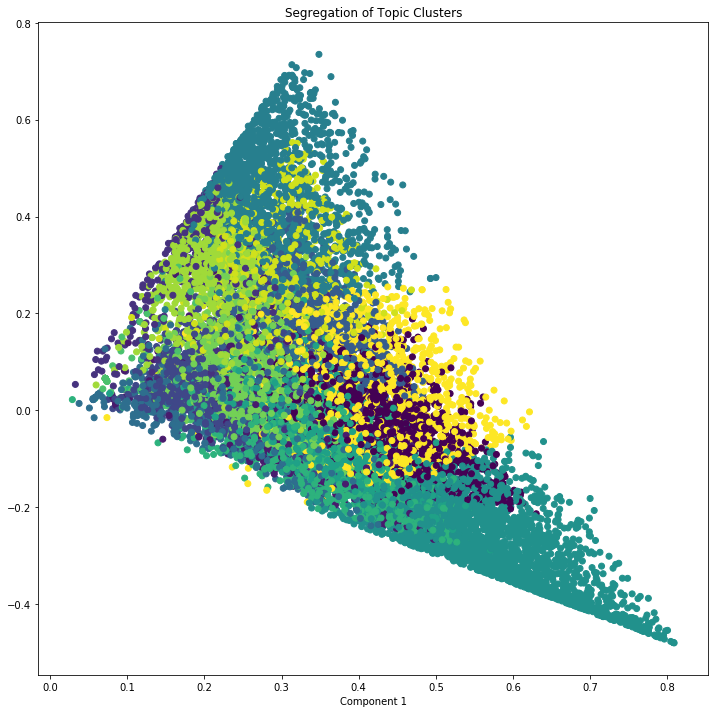

In [123]:
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

* ## tfidf dtm

In [124]:
%%time
tfidf_vectorizer = TfidfVectorizer()

dtm_tfidf = tfidf_vectorizer.fit_transform(df.text_clean_lemma4sk)
print(dtm_tfidf.shape)

(14485, 106332)
CPU times: user 4.1 s, sys: 440 ms, total: 4.54 s
Wall time: 5.1 s


In [129]:
print(tfidf_vectorizer.get_feature_names()[:10])
print(tfidf_vectorizer.get_feature_names()[-10:])

['aa', 'aaa', 'aaaruдва', 'aadolu', 'aalysis', 'aalyticks', 'aalytics', 'aarcho', 'aaroso', 'aastasia']
['єдина', 'ім', 'ірина', 'іще', 'їдем', 'اديك', 'الاستقرار', 'خالد', 'خوجة', 'فى']


In [126]:
# Materialize the sparse data
data_dense = dtm_tfidf.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum() / data_dense.size) * 100)

Sparsicity:  0.17583064257965078


In [131]:
%%time

lda_tfidf = LatentDirichletAllocation(
    n_components=30,  #like n_topics           
    max_iter=7,
    learning_method='online',
    random_state=42)

lda_tfidf.fit_transform(dtm_tfidf)

CPU times: user 1min 56s, sys: 10.2 s, total: 2min 6s
Wall time: 2min 6s


In [133]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_tfidf.score(dtm_tfidf))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_tfidf.perplexity(dtm_tfidf))

Log Likelihood:  -1605450.7354822573
Perplexity:  118765.94528872959


### -> как видно по `Perplexity`, то это значание намного упало
для справки, в tf было 6515

Create Document - Topic Matrix

In [157]:
%%time
lda_output = lda_tfidf.transform(dtm_tfidf)

CPU times: user 1.61 s, sys: 147 ms, total: 1.75 s
Wall time: 1.79 s


column names

In [158]:
topicnames = ["Topic" + str(i) for i in range(lda_tfidf.n_components)]
print(topicnames)

['Topic0', 'Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11', 'Topic12', 'Topic13', 'Topic14', 'Topic15', 'Topic16', 'Topic17', 'Topic18', 'Topic19', 'Topic20', 'Topic21', 'Topic22', 'Topic23', 'Topic24', 'Topic25', 'Topic26', 'Topic27', 'Topic28', 'Topic29']


index names

In [159]:
docnames = [
    "Doc" + str(i) for i in range(len(df.text_clean_lemma4sk.values.tolist()))
]
len(docnames)

14485

Make the pandas dataframe

In [160]:
df_document_topic = pd.DataFrame(np.round(lda_output, 2),
                                 columns=topicnames,
                                 index=docnames)
print(df_document_topic.shape)
df_document_topic.head(2)

(14485, 30)


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29
Doc0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.91,0.03,0.0,0.0,0.0,0.0,0.0,0.0
Doc1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.94,0.00,0.0,0.0,0.0,0.0,0.0,0.0


Get dominant topic for each document

In [165]:
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

In [161]:
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)


def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

In [166]:
# Apply Style

df_document_topics = df_document_topic.head(15)\
                    .style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,dominant_topic
Doc0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.91,0.03,0,0,0,0,0,0,22
Doc1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0,0,0,0,0.94,0,0,0,0,0,0,0,22
Doc2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.93,0,0,0,0,0,0,0,22
Doc3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.94,0,0,0,0,0,0,0,22
Doc4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.93,0,0,0,0,0,0,0,22
Doc5,0,0,0,0,0.07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.87,0,0,0,0,0,0,0,22
Doc6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.88,0,0,0,0,0,0,0,0,0,0,19
Doc7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.94,0,0,0,0,0,0,0,22
Doc8,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.83,0.01,0.01,0.01,0.01,0.01,0.01,0.01,22
Doc9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.9,0,0,0,0,0,0,0,22


In [167]:
df_topic_distribution = df_document_topic['dominant_topic']\
                        .value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,22,14380
1,19,104
2,27,1


### -> задействованно всего 3 топика
итого, для этого датасета использвать tf-idf не рационально

In [168]:
%%time
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(
    lda_tfidf, dtm_tfidf, tfidf_vectorizer, mds='tsne')

CPU times: user 9.5 s, sys: 694 ms, total: 10.2 s
Wall time: 34 s


In [169]:
pyLDAvis.save_html(panel, 'pyLDAvis/sklearn/tsne_tf-dtm_sk.html')

In [170]:
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
22     101.815201   80.770332       1        1  89.961791
19     -97.174911   64.110596       2        1   0.801306
4      -37.494514   49.069061       3        1   0.403816
1      -43.289730 -131.984360       4        1   0.383846
14     -29.635101  -46.171642       5        1   0.333878
28     -72.031075  -28.613981       6        1   0.332050
17       1.681184   75.441696       7        1   0.329436
10      94.138374  -66.051796       8        1   0.329243
27      13.744454  -56.496826       9        1   0.328978
29     138.162155  -37.961456      10        1   0.326528
2       22.991875 -134.625183      11        1   0.326271
15     -73.438751   19.843779      12        1   0.326035
5      -63.174351  -82.560684      13        1   0.325327
24      -1.825534  124.559341      14        1   0.324973
12      46.019604  -87.331947      15        1   0.324606
16     -31.576767    0.484717      16        1   0.324313
26       9.090955  -14.815397      17        1   0.324253
11      53.638954  -37.247498      18        1   0.324156
21      46.436596    7.916694      19        1   0.323974
20    -111.420860  -61.890198      20        1   0.322984
23       5.337583   29.067852      21        1   0.322813
8       84.725098   33.802277      22        1   0.322794
25    -120.357697    0.700442      23        1   0.322726
18      86.733009 -118.404633      24        1   0.322577
3       92.344101  -13.087295      25        1   0.322233
9      134.727493   23.854034      26        1   0.321819
6      -52.238853   97.422020      27        1   0.321819
7       52.286316  106.104324      28        1   0.321819
13     -10.362635  -93.569710      29        1   0.321819
0       44.497860   56.328339      30        1   0.321819, topic_info=       Category        Freq              Term       Total  loglift  logprob
term                                                                       
59387   Default  171.000000             новый  171.000000  30.0000  30.0000
22173   Default   95.000000            газета   95.000000  29.0000  29.0000
81433   Default   88.000000              сайт   88.000000  28.0000  28.0000
26409   Default  112.000000            данные  112.000000  27.0000  27.0000
67445   Default   55.000000            письмо   55.000000  26.0000  26.0000
88334   Default   94.000000            статья   94.000000  25.0000  25.0000
85485   Default  103.000000            служба  103.000000  24.0000  24.0000
72074   Default   95.000000             право   95.000000  23.0000  23.0000
17980   Default  200.000000              весь  200.000000  22.0000  22.0000
35809   Default   76.000000           издание   76.000000  21.0000  21.0000
29210   Default  100.000000           должный  100.000000  20.0000  20.0000
49413   Default   51.000000          материал   51.000000  19.0000  19.0000
105851  Default   78.000000          являться   78.000000  18.0000  18.0000
96945   Default   67.000000       федеральный   67.000000  17.0000  17.0000
78608   Default   42.000000          редакция   42.000000  16.0000  16.0000
101904  Default   73.000000             число   73.000000  15.0000  15.0000
85510   Default   73.000000            случай   73.000000  14.0000  14.0000
37738   Default   61.000000              июнь   61.000000  13.0000  13.0000
59367   Default   62.000000           новость   62.000000  12.0000  12.0000
62474   Default   60.000000    опубликовывать   60.000000  11.0000  11.0000
7645    Default   42.000000             автор   42.000000  10.0000  10.0000
54822   Default   52.000000        направлять   52.000000   9.0000   9.0000
26413   Default   52.000000            данный   52.000000   8.0000   8.0000
55218   Default   52.000000         настоящий   52.000000   7.0000   7.0000
47735   Default   47.000000             любой   47.000000   6.0000   6.0000
49332   Default   40.000000          массовый   4

Topic-Keyword Matrix

In [171]:
df_topic_keywords = pd.DataFrame(lda_tfidf.components_)
len(df_topic_keywords)

30

Assign Column and Index

In [172]:
df_topic_keywords.columns = tfidf_vectorizer.get_feature_names()
df_topic_keywords.index = topicnames
print(df_topic_keywords.shape)
df_topic_keywords.head()

(30, 106332)


,aa,aaa,aaaruдва,aadolu,aalysis,aalyticks,aalytics,aarcho,aaroso,aastasia,...,єдина,ім,ірина,іще,їдем,اديك,الاستقرار,خالد,خوجة,فى
Topic0,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
Topic1,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
Topic2,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
Topic3,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
Topic4,0.033333,0.033334,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,...,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333


### top 15 keywords

In [174]:
topic_keywords = show_topics(
    vectorizer=tfidf_vectorizer, lda_model=lda_tfidf, n_words=15)

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = [
    'Word ' + str(i) for i in range(df_topic_keywords.shape[1])
]
df_topic_keywords.index = [
    'Topic ' + str(i) for i in range(df_topic_keywords.shape[0])
]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,порошенко,коалиция,распускать,выборы,украина,парламент,верховный,батькивщина,назначать,распадаться,партия,внеочередной,созыв,рада,новый
Topic 1,руфер,подрезов,высотка,шпиль,покраска,котельнический,бейсджампер,богатенкова,войнов,пулково,мустанг,поздняков,ушивец,горняк,авиадиспетчер
Topic 2,мурси,джазира,краснопресненский,катарский,укарина,сабалан,муххамед,гристый,бахер,скотать,тюрьмыбывать,срифя,egyptair,сусульманин,адха
Topic 3,бруклинский,нь,брэттон,гарнер,панталео,мост,йорк,россиянин,колчин,нью,забираться,инцидент,мэр,усиливать,блазио
Topic 4,эбола,вирус,лихорадка,трамп,либерия,гвинея,сьерра,заражаться,леоне,заражение,вакцина,цуп,воз,эпидемия,выживаемость
Topic 5,макаронный,хаджимба,великорусский,мардеев,бутба,ильгизар,путный,автогонщик,можайск,малорусский,боровецкий,автоспорт,кат,пихта,бжание
Topic 6,папарацци,котиков,попутно,дугин,президентовwikileaks,чернавин,волконская,сверхлимитный,терезин,атлантика,себси,вон,прудовой,человекриа,провайдер
Topic 7,перерубать,токсикология,tass,мупа,мариупольсегодня,поговаривать,надънет,крамский,цатурян,долинский,терапияесть,сср,сам,супротив,всяческий
Topic 8,мостотрест,мостотреста,ротерберг,гришкин,ленэнерго,сзкк,варенов,концессионный,завьялов,фоуль,ivestmets,polo,аркадьевич,аэрофлот,evets
Topic 9,кличко,жуковский,обэп,ibo,кубрат,культура,сухожилие,бой,пулевой,война,знаменский,наш,австрия,гимн,редактор


In [175]:
%%time
clusters = KMeans(n_clusters=15,
                  random_state=100).fit_predict(lda_output_tfidf)

CPU times: user 1.09 s, sys: 35.9 ms, total: 1.13 s
Wall time: 1.07 s


In [176]:
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output_tfidf)

In [177]:
# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

In [178]:
# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

Component's weights: 
 [[ 0.    0.    0.    0.    0.01  0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.
   0.    0.    0.    0.    0.    0.  ]
 [ 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
   0.01  0.01  0.01  0.01  0.01  0.01  0.01  1.    0.01  0.01 -0.    0.01
   0.01  0.01  0.01  0.01  0.01  0.01]]


In [179]:
# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n",np.round(svd_model.explained_variance_ratio_, 2))

Perc of Variance Explained: 
 [0.55 0.41]


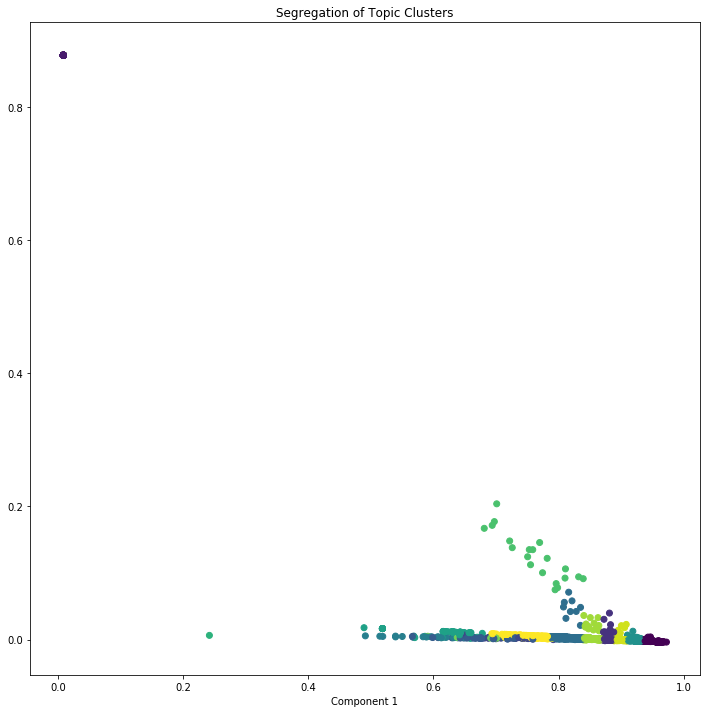

In [180]:
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

---

### подведем итоги:
* взял датасет "новой газеты", чтобы долго не ждать, тк почему-то на "ленте" долго обучается модель (ставил чтобы задействовались все ядра - но оно не работает почему-то); с это можно сделать вывод, что lda by sklearn очень долго обучается, если говорить больше чем 500k записей
* в этом ноутбуке сравнивал применение lda на CountVectorizer & TfidfVectorizer (как видно CountVectorizer показал себя лучше)

**в качестве вывода можно сказать, что lda by sklearn нам не подходит!**